In [15]:
import kagglehub

import warnings
warnings.filterwarnings("ignore")
import random

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, average_precision_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import shuffle

In [16]:
#https://www.kaggle.com/datasets/whenamancodes/fraud-detection
path = kagglehub.dataset_download("whenamancodes/fraud-detection")
print("Path to dataset files:", path)
df = pd.read_csv(path + "\\creditcard.csv")
display(df.head())
print(df.shape)

Path to dataset files: C:\Users\miaje\.cache\kagglehub\datasets\whenamancodes\fraud-detection\versions\1


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(284807, 31)


---
#### About this dataset

* Contains transactions made by credit cards in September 2013 by European cardholders.
* Presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 
* Highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.
* Contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
* Due to confidentiality issues, the original features and more background information about the data cannot be provided. 
* Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
* The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 
* Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

---
#### Pipeline

In [70]:
def fit_model(data, data_to_fit, random_state):
    iso = IsolationForest(
        n_estimators=400,
        max_samples='auto',
        contamination='auto',  #threshold to be set once SME labels have been collected
        bootstrap=False,
        n_jobs=-1,
        random_state=random_state
    )
    iso.fit(data_to_fit)
    iso_scores = pd.Series(-iso.decision_function(data), index=data.index, name="iso_scores")
    return iso_scores

In [71]:
def propose_for_review(iso_scores, top_n=200, mid_quantile_range=(0.70, 0.90), mid_sample=200, random_state=0):
    rng = np.random.default_rng(random_state)
    top_idx = iso_scores.sort_values(ascending=False).head(top_n).index
    q_low, q_high = iso_scores.quantile([mid_quantile_range[0], mid_quantile_range[1]])
    mid_pool = iso_scores[(iso_scores >= q_low) & (iso_scores <= q_high)]
    mid_n = min(mid_sample, len(mid_pool))
    mid_idx = rng.choice(mid_pool.index, size=mid_n, replace=False) if mid_n > 0 else []
    proposed = pd.Index(top_idx).append(pd.Index(mid_idx)).unique()
    queue = (
        pd.DataFrame({"if_score": iso_scores.loc[proposed]})
        .assign(priority_rank=lambda df: df["if_score"].rank(ascending=False, method="first"))
        .sort_values("priority_rank")
    )
    return queue

In [72]:
def build_labelled_data(data, iso_scores, sme_labels_batch, random_state):
    labeled_idx = data.index.intersection(sme_labels_batch.index)
    y = sme_labels_batch.loc[labeled_idx, "label"].astype(int)
    s = iso_scores.loc[labeled_idx].values
    X_lab = data.loc[labeled_idx]
    X_lab = X_lab.assign(iso_scores=s)  # add IF score as a feature
    X_lab = X_lab.assign(y_true=y)      # add SME labels as a feature
    X_lab, y = shuffle(X_lab, y, random_state=random_state) # shuffle to reduce ordering bias
    return X_lab, y, s

In [116]:
def choose_threshold(y, s, plot=False):
    precision, recall, thresholds = precision_recall_curve(y, s)

    p = precision[:-1]
    r = recall[:-1]
    f1 = 2 * p * r / (p + r + 1e-12)

    best_ix = int(np.nanargmax(f1))
    t_star = float(thresholds[best_ix])
    best_f1 = float(f1[best_ix])
    best_p, best_r = float(p[best_ix]), float(r[best_ix])

    print({"Threshold": t_star, "Best F1": best_f1, "Best Precision": best_p, "Best Recall": best_r})
    
    if plot:
        plt.plot(thresholds, p, label="Precision")
        plt.plot(thresholds, r, label="Recall")
        plt.plot(thresholds, f1, label="F1")
        plt.axvline(t_star, linestyle="--", color="red", label="Optimal Threshold")
        plt.title("Precision, Recall, and F1 vs Threshold")
        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.legend()
        plt.show()
    
    return t_star, [best_f1, best_p, best_r]

In [117]:
def collect_sample_legitimate(X_lab, t_star):
    X_lab_legit = pd.concat([
        X_lab[X_lab.y_true == 1], 
        X_lab[(X_lab.iso_scores < t_star) & (X_lab.y_true == 0)]
    ], axis=0, ignore_index=True)
    X_lab_legit = X_lab_legit.drop(columns=["iso_scores", "y_true"])
    return X_lab_legit

In [118]:
def pipeline(data, data_to_fit, threshold=0.1, random_state=42):
    # automated
    iso_scores = fit_model(data, data_to_fit, random_state)
    queue = propose_for_review(iso_scores, top_n=200, mid_quantile_range=(0.70, 0.90), mid_sample=200, random_state=random_state)

    # manual data entry - simulated for PoC
    random.seed(random_state)
    sme_labels = random.choices([1, 0], weights=[threshold, 1-threshold], k=len(queue))
    sme_labels_batch = queue.copy()
    sme_labels_batch["label"] = sme_labels

    # automated
    X_lab, y, s = build_labelled_data(data, iso_scores, sme_labels_batch, random_state)
    t_star, _ = choose_threshold(y, s, plot=True)
    return t_star, X_lab

{'Threshold': 0.19910722492340627, 'Best F1': 0.1882352941172935, 'Best Precision': 0.12213740458015267, 'Best Recall': 0.41025641025641024}


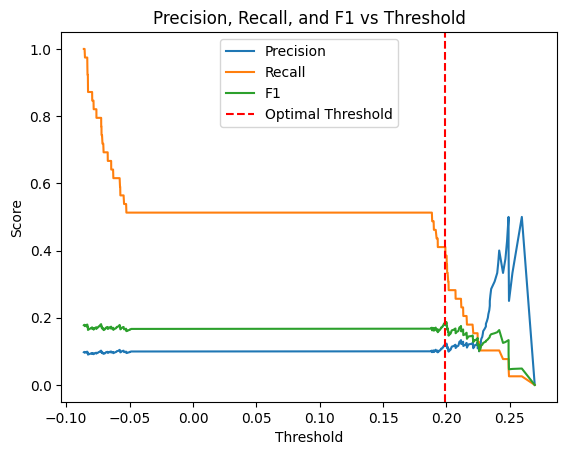

{'Threshold': -0.12405989311727705, 'Best F1': 0.3492063492059965, 'Best Precision': 0.22633744855967078, 'Best Recall': 0.7638888888888888}


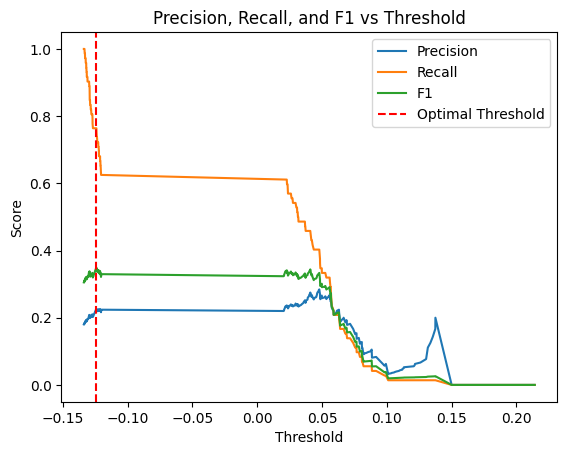

{'Threshold': -0.1447847175882755, 'Best F1': 0.0, 'Best Precision': 0.0, 'Best Recall': 1.0}


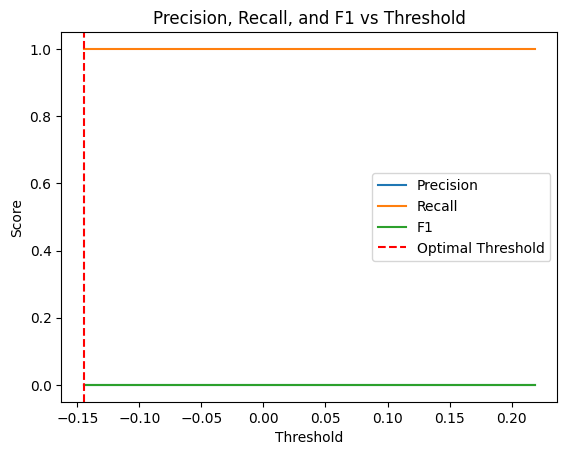

In [119]:
data = df.drop(columns=["Class"]) 
t_star, data_labelled = pipeline(data, data_to_fit=data, threshold=0.1, random_state=42)
t_star, data_labelled = pipeline(data, data_to_fit=collect_sample_legitimate(data_labelled, t_star), threshold=t_star, random_state=0)
t_star, data_labelled = pipeline(data, data_to_fit=collect_sample_legitimate(data_labelled, t_star), threshold=t_star, random_state=0)